# Chapter 12: Parallelizing Neural Network Training with PyTorch (Part 1/2)


## PyTorch and training performance

In [1]:
import torch
import numpy as np

print('PyTorch version:', torch.__version__)

np.set_printoptions(precision=3)

PyTorch version: 1.5.1


### Creating tensors in PyTorch

In [ ]:
#creat a tensor from a list using torch.tensor()
# or from a numpy array usng torch.from_numpy()

In [3]:
a = [1, 2, 3]
b = np.array([4, 5, 6], dtype=np.int32)

t_a = torch.tensor(a)
t_b = torch.from_numpy(b)

print(t_a)
print(t_b)

tensor([1, 2, 3])
tensor([4, 5, 6], dtype=torch.int32)


In [4]:
torch.is_tensor(a), torch.is_tensor(t_a)

(False, True)

In [ ]:
#creat tensors directly using torch

In [11]:
t_ones = torch.ones(2, 3)

t_ones.shape

torch.Size([2, 3])

In [12]:
print(t_ones)

tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [13]:
rand_tensor = torch.rand(2,3)

print(rand_tensor)

tensor([[0.8081, 0.8601, 0.0870],
        [0.6340, 0.1330, 0.5721]])


### Manipulating the data type and shape of a tensor

In [14]:
t_a_new = t_a.to(torch.int64)

print(t_a_new.dtype)

torch.int64


In [15]:
t = torch.rand(3, 5)

t_tr = torch.transpose(t, 0, 1)
print(t.shape, ' --> ', t_tr.shape)

torch.Size([3, 5])  -->  torch.Size([5, 3])


In [16]:
t = torch.zeros(30)

t_reshape = t.reshape(5, 6)

print(t_reshape.shape)

torch.Size([5, 6])


In [17]:
t = torch.zeros(1, 2, 1, 4, 1)

t_sqz = torch.squeeze(t, 2)

print(t.shape, ' --> ', t_sqz.shape)

torch.Size([1, 2, 1, 4, 1])  -->  torch.Size([1, 2, 4, 1])


### Applying mathematical operations to tensors

In [7]:
torch.manual_seed(1)

#t1 = 2 * torch.rand(5, 2) - 1
t1=2*torch.ones(5,2)
t2 = torch.normal(mean=0, std=1, size=(5, 2))
print(t2)

tensor([[ 0.6614,  0.2669],
        [ 0.0617,  0.6213],
        [-0.4519, -0.1661],
        [-1.5228,  0.3817],
        [-1.0276, -0.5631]])


In [11]:
#Element wise multiplication
#t3 = torch.multiply(t1, t2) 
t3 = torch.mul(t1, t2) #this is the old version in torch 1.5
print(t3)

tensor([[ 1.3227,  0.5338],
        [ 0.1234,  1.2426],
        [-0.9038, -0.3323],
        [-3.0455,  0.7634],
        [-2.0552, -1.1261]])


In [9]:
t4 = torch.mean(t1, axis=0)
print(t4)

tensor([2., 2.])


In [12]:
#matrix multiplication
t5 = torch.matmul(t1, torch.transpose(t2, 0, 1))

print(t5)

tensor([[ 1.8566,  1.3660, -1.2361, -2.2822, -3.1813],
        [ 1.8566,  1.3660, -1.2361, -2.2822, -3.1813],
        [ 1.8566,  1.3660, -1.2361, -2.2822, -3.1813],
        [ 1.8566,  1.3660, -1.2361, -2.2822, -3.1813],
        [ 1.8566,  1.3660, -1.2361, -2.2822, -3.1813]])


In [22]:
t6 = torch.matmul(torch.transpose(t1, 0, 1), t2)

print(t6)

tensor([[ 1.7453,  0.3392],
        [-1.6038, -0.2180]])


In [23]:
#compute norm
norm_t1 = torch.linalg.norm(t1, ord=2, dim=1)

print(norm_t1)

tensor([0.6785, 0.5078, 1.1162, 0.5488, 0.1853])


In [24]:
np.sqrt(np.sum(np.square(t1.numpy()), axis=1))

array([0.678, 0.508, 1.116, 0.549, 0.185], dtype=float32)

### Split, stack, and concatenate tensors

In [25]:
torch.manual_seed(1)

t = torch.rand(6)

print(t)

t_splits = torch.chunk(t, 3)

[item.numpy() for item in t_splits]

tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999])


[array([0.758, 0.279], dtype=float32),
 array([0.403, 0.735], dtype=float32),
 array([0.029, 0.8  ], dtype=float32)]

In [26]:
torch.manual_seed(1)
t = torch.rand(5)

print(t)

t_splits = torch.split(t, split_size_or_sections=[3, 2])
 
[item.numpy() for item in t_splits]

tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293])


[array([0.758, 0.279, 0.403], dtype=float32),
 array([0.735, 0.029], dtype=float32)]

In [27]:
A = torch.ones(3)
B = torch.zeros(2)

C = torch.cat([A, B], axis=0)
print(C)

tensor([1., 1., 1., 0., 0.])


In [28]:
A = torch.ones(3)
B = torch.zeros(3)

S = torch.stack([A, B], axis=1)
print(S)

tensor([[1., 0.],
        [1., 0.],
        [1., 0.]])


## Building input pipelines in PyTorch

1. We ususally train a neural network using a stochastic gradient descent (SGD) algorithm 
2. Recall SGD uses a subset of training samples, or a batch, to compute the loss function
3. At each iterative step, we only need to use a batch of data samples
4. We need a data input pipeline that can load data batches interatively, and preprocess the data.

PyTorch provides two classes, Dataset and Dataloader, for data loading, shuffling, and batching

### Creating a PyTorch DataLoader from existing tensors

1. If the data already exists in the form of a tensor object, a Python list, or a NumPy array, we can easily create a dataset loader using the torch.utils.data.DataLoader() class.

2. It returns an object of the DataLoader class, which we can use to iterate through the individual elements in the input dataset. 

In [13]:
from torch.utils.data import DataLoader

t = torch.arange(6, dtype=torch.float32)
data_loader = DataLoader(t)

In [14]:
for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


In [15]:
data_loader = DataLoader(t, batch_size=3, drop_last=False)

for i, batch in enumerate(data_loader, 1):
    print(f'batch {i}:', batch)

batch 1: tensor([0., 1., 2.])
batch 2: tensor([3., 4., 5.])


### Combining two tensors into a joint dataset

1. Often, we may have the data in two (or possibly more) tensors. For example, we could have a tensor for features and a tensor for labels. 

2. In such cases, we need to build a dataset that combines these tensors, which will allow us to retrieve the elements of these tensors in tuples.

In [32]:
from torch.utils.data import Dataset

class JointDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [33]:
torch.manual_seed(1)

t_x = torch.rand([4, 3], dtype=torch.float32)
t_y = torch.arange(4)
joint_dataset = JointDataset(t_x, t_y)

# Or use TensorDataset directly
from torch.utils.data import TensorDataset
joint_dataset = TensorDataset(t_x, t_y)

for example in joint_dataset:
    print('  x: ', example[0], 
          '  y: ', example[1])

  x:  tensor([0.7576, 0.2793, 0.4031])   y:  tensor(0)
  x:  tensor([0.7347, 0.0293, 0.7999])   y:  tensor(1)
  x:  tensor([0.3971, 0.7544, 0.5695])   y:  tensor(2)
  x:  tensor([0.4388, 0.6387, 0.5247])   y:  tensor(3)


### Shuffle, batch, and repeat

In [34]:
torch.manual_seed(1)
data_loader = DataLoader(dataset=joint_dataset, batch_size=2, shuffle=True)

for i, batch in enumerate(data_loader, 1):
        print(f'batch {i}:', 'x:', batch[0], 
              '\n         y:', batch[1])
        
for epoch in range(2):
    print(f'epoch {epoch+1}')
    for i, batch in enumerate(data_loader, 1):
        print(f'batch {i}:', 'x:', batch[0], 
              '\n         y:', batch[1])

batch 1: x: tensor([[0.3971, 0.7544, 0.5695],
        [0.7576, 0.2793, 0.4031]]) 
         y: tensor([2, 0])
batch 2: x: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]]) 
         y: tensor([1, 3])
epoch 1
batch 1: x: tensor([[0.7576, 0.2793, 0.4031],
        [0.3971, 0.7544, 0.5695]]) 
         y: tensor([0, 2])
batch 2: x: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]]) 
         y: tensor([1, 3])
epoch 2
batch 1: x: tensor([[0.4388, 0.6387, 0.5247],
        [0.3971, 0.7544, 0.5695]]) 
         y: tensor([3, 2])
batch 2: x: tensor([[0.7576, 0.2793, 0.4031],
        [0.7347, 0.0293, 0.7999]]) 
         y: tensor([0, 1])


### Creating a dataset from files on your local storage disk

In [35]:
import pathlib

imgdir_path = pathlib.Path('cat_dog_images')

file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

print(file_list)

['cat_dog_images/cat-01.jpg', 'cat_dog_images/cat-02.jpg', 'cat_dog_images/cat-03.jpg', 'cat_dog_images/dog-01.jpg', 'cat_dog_images/dog-02.jpg', 'cat_dog_images/dog-03.jpg']


Image shape:  (900, 1200, 3)
Image shape:  (900, 1200, 3)
Image shape:  (900, 742, 3)
Image shape:  (800, 1200, 3)
Image shape:  (800, 1200, 3)
Image shape:  (900, 1200, 3)


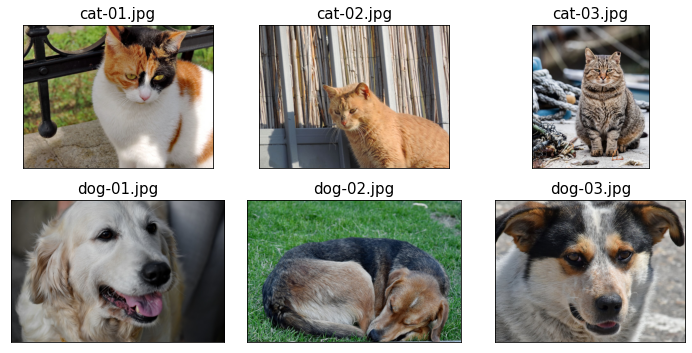

In [36]:
import matplotlib.pyplot as plt
import os
from PIL import Image


fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(file_list):
    img = Image.open(file)
    print('Image shape: ', np.array(img).shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    
#plt.savefig('figures/12_03.pdf')
plt.tight_layout()
plt.show()

In [37]:
labels = [1 if 'dog' in os.path.basename(file) else 0
          for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


In [38]:
class ImageDataset(Dataset):
    def __init__(self, file_list, labels):
        self.file_list = file_list
        self.labels = labels

    def __getitem__(self, index):
        file = self.file_list[index]      
        label = self.labels[index]
        return file, label

    def __len__(self):
        return len(self.labels)
    
image_dataset = ImageDataset(file_list, labels)
for file, label in image_dataset:
    print(file, label)

cat_dog_images/cat-01.jpg 0
cat_dog_images/cat-02.jpg 0
cat_dog_images/cat-03.jpg 0
cat_dog_images/dog-01.jpg 1
cat_dog_images/dog-02.jpg 1
cat_dog_images/dog-03.jpg 1


In [39]:
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
    def __getitem__(self, index):
        img = Image.open(self.file_list[index])        
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label
    def __len__(self):
        return len(self.labels)

img_height, img_width = 80, 120
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width)),
])
    
image_dataset = ImageDataset(file_list, labels, transform)

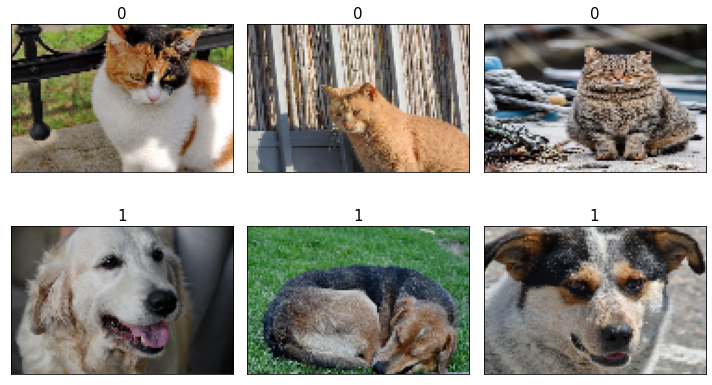

In [40]:
fig = plt.figure(figsize=(10, 6))
for i, example in enumerate(image_dataset):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=15)
    
plt.tight_layout()
plt.savefig('figures/12_04.pdf')
plt.show()